In [3]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import time 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [4]:


# 커스텀 BayesianLSTM 셀 구현
class BayesianLSTMCell(tf.keras.layers.LSTMCell):
    def __init__(self, units, **kwargs):
        super(BayesianLSTMCell, self).__init__(units, **kwargs)
        self.units = units
        self.kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn()
        self.kernel_prior_fn = lambda dtype, shape, name, trainable, add_variable_fn: tfp.layers.default_multivariate_normal_fn(
            dtype=dtype, shape=shape, name=name, trainable=trainable, add_variable_fn=add_variable_fn)
        self.recurrent_kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn()
        self.recurrent_kernel_prior_fn = lambda dtype, shape, name, trainable, add_variable_fn: tfp.layers.default_multivariate_normal_fn(
            dtype=dtype, shape=shape, name=name, trainable=trainable, add_variable_fn=add_variable_fn)

    def build(self, input_shape):
        self.kernel_posterior = self.kernel_posterior_fn(
            dtype=tf.float32,
            shape=[input_shape[-1], self.units * 4],
            name='kernel_posterior',
            trainable=True,
            add_variable_fn=self.add_weight
        )
        self.kernel_prior = self.kernel_prior_fn(
            dtype=tf.float32,
            shape=[input_shape[-1], self.units * 4],
            name='kernel_prior',
            trainable=True,
            add_variable_fn=self.add_weight
        )
        self.recurrent_kernel_posterior = self.recurrent_kernel_posterior_fn(
            dtype=tf.float32,
            shape=[self.units, self.units * 4],
            name='recurrent_kernel_posterior',
            trainable=True,
            add_variable_fn=self.add_weight
        )
        self.recurrent_kernel_prior = self.recurrent_kernel_prior_fn(
            dtype=tf.float32,
            shape=[self.units, self.units * 4],
            name='recurrent_kernel_prior',
            trainable=True,
            add_variable_fn=self.add_weight
        )
        super(BayesianLSTMCell, self).build(input_shape)

    def call(self, inputs, states, training=None):
        self.kernel = self.kernel_posterior.sample()
        self.recurrent_kernel = self.recurrent_kernel_posterior.sample()
        return super(BayesianLSTMCell, self).call(inputs, states, training=training)

def build_bayesian_lstm_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        tf.keras.layers.RNN(BayesianLSTMCell(10)),
        Dense(1)
    ])
    # model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
    # return model
    kl_divergence = sum(model.losses)
    model.compile(optimizer=Adam(learning_rate=0.01),
                  loss=lambda y_true, 
                  y_pred: tf.keras.losses.mean_squared_error(y_true, y_pred) + kl_divergence)
    return model

In [5]:

def load_and_prepare_data(data_file):
    """
    주어진 CSV 파일을 불러와 기본 전처리를 수행.
    
    매개변수:
    - data_file: CSV 파일의 경로
    
    Returns:
    - data: 전처리된 데이터프레임
    """
    
    # Load the data
    data = pd.read_csv(data_file)

    # Prepare the data
    data['Time'] = pd.to_datetime(data['Time'])


    data['Target_MHC_Water_Level'] = data['MHC_Water_Level'].shift(-3)

    # Fill NaN values in 'Target_MHC_Water_Level' with the last value of 'MHC_Water_Level'
    data['Target_MHC_Water_Level'].fillna(data['MHC_Water_Level'].iloc[-1], inplace=True)
    
    
    
    # # Add lag variables for MHC_Water_Level from t-1 to t-10
    # for i in range(3, 11):
    #     data[f'MHC_Water_Level_lag_{i}'] = data['MHC_Water_Level'].shift(i)
    # data.dropna(inplace=True)
    
    
    #Add lag variables for MHC_Water_Level from t-1 to t-10
    for i in range(3, 6):
        data[f'MHC_Water_Level_lag_{i}'] = data['MHC_Water_Level'].shift(i)
        data[f'MH_Water_Level_lag_{i}'] = data['MH_Water_Level'].shift(i)
        data[f'PG_Water_Level_lag_{i}'] = data['PG_Water_Level'].shift(i)
        data[f'HH_Water_Level_lag_{i}'] = data['HH_Water_Level'].shift(i)
        data[f'GG_Water_Level_lag_{i}'] = data['GG_Water_Level'].shift(i)
    data.dropna(inplace=True)


    


    return data

def split_data(data):
    """
    데이터를 학습 및 테스트 데이터로 분할.
    
    매개변수:
    - data: 전체 데이터프레임
    
    Returns:
    - train_data: 학습 데이터
    - test_data: 테스트 데이터
    """
    # Split data
    train_size = int(len(data) * 0.8)
    train_data = data.iloc[:train_size]
    test_data = data.iloc[train_size:]
    
    return train_data, test_data

In [6]:


def bayes_prepare_train_test_sets(train_data, test_data):
    X_train = train_data.drop(columns=['Time', 'Target_MHC_Water_Level']).values
    y_train = train_data['Target_MHC_Water_Level'].values
    X_test = test_data.drop(columns=['Time', 'Target_MHC_Water_Level']).values
    y_test = test_data['Target_MHC_Water_Level'].values
    return X_train, y_train, X_test, y_test

In [7]:

                data = load_and_prepare_data('water_data.csv')
                train_data, test_data = split_data(data)
                X_train, y_train, X_test, y_test = bayes_prepare_train_test_sets(train_data, test_data)
                
                
                scaler_X = MinMaxScaler(feature_range=(0, 1))
                scaler_y = MinMaxScaler(feature_range=(0, 1))
                X_train_scaled = scaler_X.fit_transform(X_train)
                X_test_scaled = scaler_X.transform(X_test)
                y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
                
                model = build_bayesian_lstm_model(input_shape=(X_train_scaled.shape[1], 1))
                X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
                X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
                model.fit(X_train_scaled, y_train_scaled, epochs=10, batch_size=32, verbose=1)

2024-08-12 12:15:53.077074: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-08-12 12:15:53.077247: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-08-12 12:15:53.077386: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-08-12 12:15:53.081192: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2024-08-12 12:15:53.081273: W te

Epoch 1/10
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
501/501 [==============================] - 6s 10ms/step - loss: 9.1897e-04
Epoch 2/10
501/501 [==============================] - 5s 10ms/step - loss: 6.4493e-04
Epoch 3/10
501/501 [==============================] - 5s 10ms/step - loss: 6.1359e-04
Epoch 4/10
501/501 [==============================] - 4s 9ms/step - loss: 5.5442e-04
Epoch 5/10
501/501 [==============================] - 4s 9ms/step - loss: 5.3998e-04
Epoch 6/10
501/501 [==============================] - 5s 9ms/step - loss: 5.1617e-04
Epoch 7/10
501/501 [==============================] - 4s 9ms/step - loss: 5.0629e-04
Epoch 8/10
501/501 [==============================] - 5s 9ms/step - loss: 4.9381e-04
Epoch 9/10
501/501 [==============================] - 5s 10ms/step - loss: 4.7908e-04
Epoch 10/10
501/501 [=========

In [8]:
bayes_pred_uncer =pd.read_csv('bayes_pred_uncer.csv')


In [69]:
def save_bayesian_visual_predictions_to_csv(model, 
                                            x,
                                            time_points, 
                                            scaler_y,
                                            n_iter=100):
    """
    예측 결과를 CSV 파일로 저장하는 함수
    
    매개변수:
    - model: 학습된 Bayesian LSTM 모델
    - x: 테스트 데이터의 특성 (정규화된 상태)
    - time_points: 시간대 포인트 (원래 시간 데이터)
    - scaler_y: 타겟 변수의 스케일러
    - n_iter: 예측 수행 횟수
    - filename: 저장할 CSV 파일 이름
    """

    
    # time_points = time_points[-3:]
    # print(time_points)
    
    predictions_scaled = np.zeros((len(time_points), n_iter))
    
    for j in range(n_iter):
        predictions_scaled[:, j] = model(x, training=True).numpy().flatten()
    
    # 예측 결과 역정규화
    predictions = scaler_y.inverse_transform(predictions_scaled)
    
    # 시간대와 예측 결과를 DataFrame으로 변환
    df_predictions = pd.DataFrame(
                                  predictions, 
                                  columns=[f'Prediction_{i+1}' for i in range(n_iter)])
    df_predictions.insert(0, 'Time', time_points)

    
    return df_predictions


In [71]:
import time


time_points = bayes_pred_uncer['Time']

# 시작 시간 기록
start_time = time.time()

# 실행할 코드
bayes_ppd_data = save_bayesian_visual_predictions_to_csv(model, 
                                                         X_test_scaled,
                                                         time_points, 
                                                         scaler_y,
                                                         n_iter=300)

# 종료 시간 기록
end_time = time.time()

# 경과 시간 계산
elapsed_time = end_time - start_time
print(f"Execution time: {elapsed_time} seconds")


Execution time: 61.48241329193115 seconds


In [72]:
bayes_ppd_data = bayes_ppd_data.assign(Time=time_points.values)


In [26]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import pandas as pd

# @tf.function
def predict_and_save_bayesian_visual_predictions(model, 
                                                 x, 
                                                 time_points, 
                                                 scaler_y, 
                                                 true_value,
                                                 n_iter=5000):
    """
    Bayesian LSTM 모델의 예측 결과를 여러 번 수행하여 불확실성과 신뢰 구간을 포함한
    예측 분포를 계산하고 이를 DataFrame으로 반환하는 함수.
    
    매개변수:
    - model: 학습된 Bayesian LSTM 모델
    - x: 테스트 데이터의 특성 (정규화된 상태)
    - time_points: 시간대 포인트 (원래 시간 데이터)
    - scaler_y: 타겟 변수의 스케일러
    - n_iter: 예측 수행 횟수
    
    반환값:
    - df_predictions: 예측 결과와 신뢰 구간을 포함한 DataFrame
    """

    # 여러 번의 예측 수행
    result = tf.TensorArray(tf.float32, size=n_iter)
    for i in tf.range(n_iter):
        result = result.write(i, model(x, training=True))
    result = result.stack()  # (n_iter, batch_size, output_size)
    
    # 평균 예측 값 계산
    prediction = tf.reduce_mean(result, axis=0)
    
    # 불확실성 계산 (표준편차)
    uncertainty = tf.math.reduce_std(result, axis=0)
    
    # 95% 신뢰구간 (credible interval) 계산
    lower_bound = tfp.stats.percentile(result, 2.5, axis=0)
    upper_bound = tfp.stats.percentile(result, 97.5, axis=0)
    
    # 예측 결과 역정규화
    prediction = scaler_y.inverse_transform(prediction.numpy())
    lower_bound = scaler_y.inverse_transform(lower_bound.numpy())
    upper_bound = scaler_y.inverse_transform(upper_bound.numpy())
    
    # 각 예측을 역정규화하고 DataFrame에 포함시키기 위해 loop
    predictions_scaled = np.zeros((len(time_points), n_iter))
    for j in range(n_iter):
        predictions_scaled[:, j] = scaler_y.inverse_transform(result[j].numpy().flatten().reshape(-1, 1)).flatten()

    # 시간대와 예측 결과를 DataFrame으로 변환
    df_predictions = pd.DataFrame(predictions_scaled, 
                                  columns=[f'Prediction_{i+1}' for i in range(n_iter)])
    df_predictions.insert(0, 'Time', time_points)
    df_predictions['Lower_Bound'] = lower_bound.flatten()
    df_predictions['Upper_Bound'] = upper_bound.flatten()
    df_predictions['Mean_Prediction'] = prediction.flatten()
    df_predictions['Uncertainty'] = uncertainty.numpy().flatten()
    df_predictions['True_value'] = true_value

    
    # 열 순서 변경: Mean_Prediction, Uncertainty, Lower_Bound, Upper_Bound, Time + 나머지 Prediction 열
    cols = ['Time', 'True_value', 'Mean_Prediction', 'Uncertainty', 'Lower_Bound', 'Upper_Bound'] + [col for col in df_predictions.columns if col.startswith('Prediction_')]
    df_predictions = df_predictions[cols]
    
    return df_predictions


In [38]:
from tqdm import tqdm

def predict_and_save_bayesian_visual_predictions(model, 
                                                 x, 
                                                 time_points, 
                                                 scaler_y, 
                                                 true_value,
                                                 n_iter=50):
    """
    Bayesian LSTM 모델의 예측 결과를 여러 번 수행하여 불확실성과 신뢰 구간을 포함한
    예측 분포를 계산하고 이를 DataFrame으로 반환하는 함수.
    
    매개변수:
    - model: 학습된 Bayesian LSTM 모델
    - x: 테스트 데이터의 특성 (정규화된 상태)
    - time_points: 시간대 포인트 (원래 시간 데이터)
    - scaler_y: 타겟 변수의 스케일러
    - n_iter: 예측 수행 횟수
    
    반환값:
    - df_predictions: 예측 결과와 신뢰 구간을 포함한 DataFrame
    """

    # 여러 번의 예측 수행
    result = tf.TensorArray(tf.float32, size=n_iter)
    for i in tqdm(range(n_iter), desc="Predictions"):
        result = result.write(i, model(x, training=True))
    result = result.stack()  # (n_iter, batch_size, output_size)
    
    # 평균 예측 값 계산
    prediction = tf.reduce_mean(result, axis=0)
    
    # 불확실성 계산 (표준편차)
    uncertainty = tf.math.reduce_std(result, axis=0)
    
    # 95% 신뢰구간 (credible interval) 계산
    lower_bound = tfp.stats.percentile(result, 2.5, axis=0)
    upper_bound = tfp.stats.percentile(result, 97.5, axis=0)
    
    # 예측 결과 역정규화
    prediction = scaler_y.inverse_transform(prediction.numpy())
    lower_bound = scaler_y.inverse_transform(lower_bound.numpy())
    upper_bound = scaler_y.inverse_transform(upper_bound.numpy())
    
    # 각 예측을 역정규화하고 DataFrame에 포함시키기 위해 loop
    predictions_scaled = np.zeros((len(time_points), n_iter))
    for j in range(n_iter):
        predictions_scaled[:, j] = scaler_y.inverse_transform(result[j].numpy().flatten().reshape(-1, 1)).flatten()

    # 시간대와 예측 결과를 DataFrame으로 변환
    df_predictions = pd.DataFrame(predictions_scaled, 
                                  columns=[f'Prediction_{i+1}' for i in range(n_iter)])
    df_predictions.insert(0, 'Time', time_points)
    df_predictions['Lower_Bound'] = lower_bound.flatten()
    df_predictions['Upper_Bound'] = upper_bound.flatten()
    df_predictions['Mean_Prediction'] = prediction.flatten()
    df_predictions['Uncertainty'] = uncertainty.numpy().flatten()
    df_predictions['True_Value'] = true_value
    
    # 열 순서 변경: Mean_Prediction, Uncertainty, Lower_Bound, Upper_Bound, Time + 나머지 Prediction 열
    cols = ['Time', 'True_Value', 'Mean_Prediction', 'Uncertainty', 'Lower_Bound', 'Upper_Bound'] + [col for col in df_predictions.columns if col.startswith('Prediction_')]
    df_predictions = df_predictions[cols]
    
    return df_predictions


In [27]:
test_data['MHC_Water_Level']

16022    1.50
16023    1.49
16024    1.50
16025    1.49
16026    1.49
         ... 
20022    1.51
20023    1.50
20024    1.50
20025    1.50
20026    1.49
Name: MHC_Water_Level, Length: 4005, dtype: float64

In [39]:
# 예측 및 불확실성 계산, Bayesian PPD 데이터 생성
time_points = test_data["Time"] + pd.Timedelta(hours=3)
true_value = test_data['MHC_Water_Level']
bayes_ppd_data = predict_and_save_bayesian_visual_predictions(model, 
                                                              X_test_scaled, 
                                                              time_points,
                                                              scaler_y,
                                                              true_value, 
                                                              n_iter=50)

# # 예측 데이터 정리 및 저장
# bayes_pred_uncer = pd.DataFrame({
#     'Time': time_points,
#     "True_Value": test_data['MHC_Water_Level'].shift(-3),
#     "Prediction": bayes_ppd_data['Mean_Prediction'],
#     "Uncertainty": bayes_ppd_data['Uncertainty']
# })

Predictions: 100%|██████████| 50/50 [00:10<00:00,  4.97it/s]


In [32]:
bayes_ppd_data = bayes_ppd_data.assign(Time=time_points.values)
bayes_ppd_data = bayes_ppd_data.assign(True_value=true_value.values)


In [36]:
bayes_ppd_data['True_value'] = bayes_ppd_data['True_value'].shift(-3)

In [37]:
bayes_ppd_data

,Time,True_value,Mean_Prediction,Uncertainty,Lower_Bound,Upper_Bound,Prediction_1,Prediction_2,Prediction_3,Prediction_4,...,Prediction_41,Prediction_42,Prediction_43,Prediction_44,Prediction_45,Prediction_46,Prediction_47,Prediction_48,Prediction_49,Prediction_50
0,2024-02-27 18:00:00,1.49,1.533030,0.001491,1.509882,1.559967,1.531343,1.529574,1.515125,1.540432,...,1.539271,1.534396,1.512478,1.527979,1.529423,1.558028,1.555886,1.535634,1.522156,1.506619
1,2024-02-27 19:00:00,1.49,1.526218,0.001494,1.503145,1.553415,1.524679,1.522624,1.508402,1.533628,...,1.532550,1.527484,1.505556,1.521043,1.522524,1.551328,1.549004,1.528852,1.515445,1.499717
2,2024-02-27 20:00:00,1.49,1.526531,0.001494,1.503426,1.553564,1.524946,1.522968,1.508635,1.533849,...,1.532861,1.527820,1.505932,1.521429,1.522813,1.551645,1.549382,1.529125,1.515733,1.500005
3,2024-02-27 21:00:00,1.49,1.524298,0.001495,1.501251,1.551419,1.522817,1.520737,1.506380,1.531610,...,1.530683,1.525562,1.503582,1.519196,1.520543,1.549434,1.547167,1.526813,1.513484,1.497736
4,2024-02-27 22:00:00,1.49,1.523542,0.001495,1.500450,1.550647,1.522054,1.519937,1.505638,1.530846,...,1.529947,1.524819,1.502856,1.518415,1.519820,1.548699,1.546374,1.526080,1.512771,1.496940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4000,2024-08-12 10:00:00,1.50,1.373650,0.001406,1.349979,1.402773,1.370621,1.366626,1.362019,1.373457,...,1.389051,1.373958,1.349979,1.370590,1.367581,1.397506,1.388265,1.369187,1.365716,1.354544
4001,2024-08-12 11:00:00,1.49,1.371779,0.001407,1.348004,1.400941,1.368783,1.364775,1.360146,1.371593,...,1.387215,1.372074,1.348004,1.368702,1.365663,1.395638,1.386446,1.367255,1.363875,1.352679
4002,2024-08-12 12:00:00,NaN,1.372071,0.001407,1.348276,1.401292,1.369061,1.365165,1.360495,1.371904,...,1.387550,1.372390,1.348276,1.369012,1.365946,1.395915,1.386675,1.367525,1.364121,1.353006
4003,2024-08-12 13:00:00,NaN,1.370692,0.001406,1.346948,1.399895,1.367728,1.363734,1.359066,1.370491,...,1.386147,1.370970,1.346948,1.367607,1.364627,1.394517,1.385329,1.366164,1.362802,1.351601


In [ ]:
# # CSV 파일로 저장
# bayes_pred_uncer.to_csv('../streamlit/data/bayes_pred_uncer.csv', index=False)
# bayes_ppd_data.to_csv('../streamlit/data/bayesian_ppd_visual.csv', index=False)

# print('Bayesian LSTM Model Learning & Prediction Finish\n')

---

In [40]:
check_data = pd.read_csv('new_new_data.csv')

In [49]:
check_data.columns[1]

'True_Value'

In [44]:
import matplotlib.pyplot as plt
import pandas as pd

# trace plot을 그리기 위해 'Prediction_'으로 시작하는 모든 열을 추출합니다.
prediction_columns = [col for col in check_data.columns if col.startswith('Prediction_')]

# # 각 예측에 대해 trace plot을 그립니다.
# fig, axes = plt.subplots(len(prediction_columns), 1, figsize=(10, 7), sharex=True)

# for i, col in enumerate(prediction_columns):
#     axes[i].plot(pred_data['Time'], pred_data[col])
#     axes[i].set_title(col)

# plt.xlabel('Time')
# plt.show()


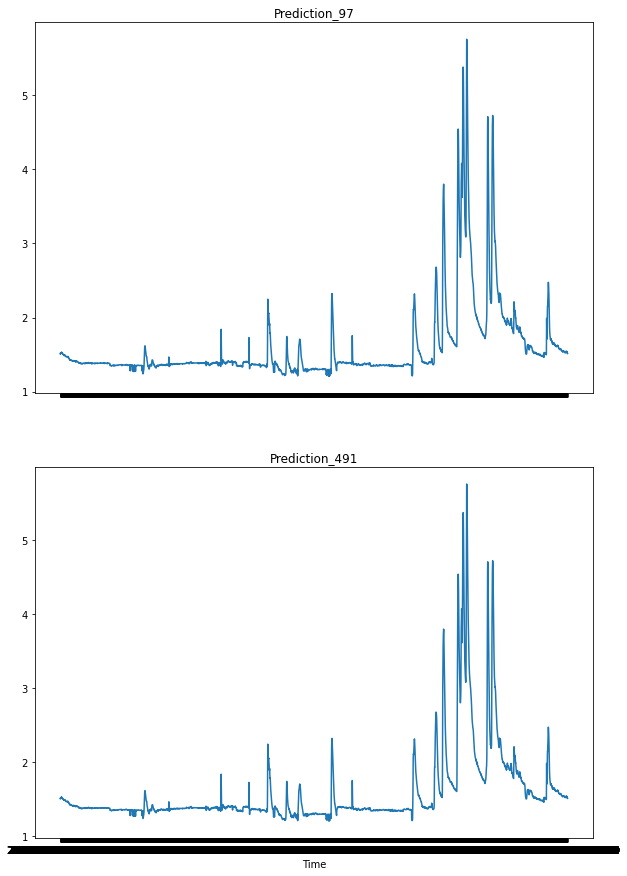

In [47]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 예측 열 목록에서 샘플링
sampled_columns = np.random.choice(prediction_columns, size=2, replace=False)

# 선택된 예측 값에 대해 trace plot을 그립니다.
fig, axes = plt.subplots(len(sampled_columns), 1, figsize=(10, 15), sharex=True)

for i, col in enumerate(sampled_columns):
    axes[i].plot(check_data['Time'], check_data[col])
    axes[i].set_title(col)

plt.xlabel('Time')
plt.show()


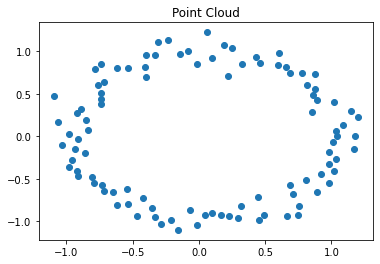

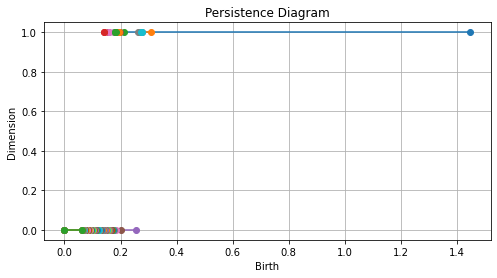

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import gudhi as gd

# 2D 점 구름 데이터 생성 (원형 패턴)
np.random.seed(0)
theta = np.linspace(0, 2 * np.pi, 100)
r = 1 + 0.1 * np.random.randn(100)
x = r * np.cos(theta)
y = r * np.sin(theta)
points = np.vstack([x, y]).T

# 점 구름 시각화
plt.scatter(points[:, 0], points[:, 1])
plt.title("Point Cloud")
plt.show()

# 심플렉스 복합체 생성
rips_complex = gd.RipsComplex(points=points, max_edge_length=2.0)
simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)

# 지속적 호몰로지 계산
diag = simplex_tree.persistence()

# 지속적 호몰로지 다이어그램 시각화 (matplotlib 사용)
plt.figure(figsize=(8, 4))
for dimension, persistence_pair in diag:
    birth, death = persistence_pair
    if death != float('inf'):  # 무한대 값 제외
        plt.plot([birth, death], [dimension, dimension], 'o-', label=f'Dimension {dimension}')

plt.xlabel("Birth")
plt.ylabel("Dimension")
plt.title("Persistence Diagram")
plt.grid(True)
plt.show()


In [57]:
import smtplib

EMAIL_USER = "nusnugehy@gmail.com"
EMAIL_PASSWORD = "iedeaaqadhylliqa"

try:
    server = smtplib.SMTP('smtp.gmail.com', 587)
    server.starttls()
    server.login(EMAIL_USER, EMAIL_PASSWORD)
    print("Logged in successfully")
    server.quit()
except smtplib.SMTPAuthenticationError as e:
    print(f"Failed to authenticate: {e}")
except Exception as e:
    print(f"An error occurred: {e}")


Logged in successfully
